# Investigation Using MNIST Data
\
In this notebook we will be using TensorFLow and Keras packages to explore machine learning topics in particular investigating the MNIST data.

In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style 
import matplotlib as mpl


#Set default figure size
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#For debugging problems
print(tf.__version__)

2.2.0


In [2]:
mnist = keras.datasets.mnist   #The original handwritten digit MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#rescaling images so that they are in range 0-1
train_images=train_images/255.0
test_images=test_images/255.0

In [3]:
def add_noise(img,y_noise):
    """
    Inputs:
    img     numpy array that represents image
    y_noise maximum value of noise that can be added 
    Returns:
    image with added noise
    """
    #random noise contribution drawn from a uniform distribution from 0-y_noise
    noise = np.random.rand(img.shape[0],img.shape[1],img.shape[2])*y_noise 
    return img + noise

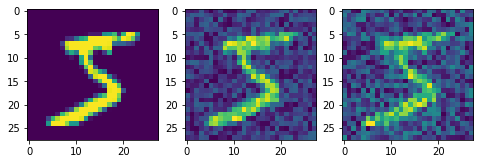

In [4]:
#plotting the same images with different noises to check add_noise works
plt.figure(figsize=(8,8))
plt.subplot(1,3,1)
plt.imshow(train_images[0])
plt.subplot(1,3,2)
plt.imshow(add_noise(train_images,0.5)[0])
plt.subplot(1,3,3)
plt.imshow(add_noise(train_images,0.9)[0])

### Building the Neural Network
We will be using keras to build the network and will be using the simple case of adding the layers sequentially.

In [5]:
#initialising the model
model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28,28)),
        keras.layers.Dense(128,activation='sigmoid'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dense(10)])
#this model is excesive for training with out noise but when 
#training with noise I found that this worked a lot better

In [6]:
#compiling model so that we can see how well the model is doing
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(lr=1.0),
              metrics=['accuracy'])

In [7]:
#training the model on images without noise
history=model.fit(train_images, train_labels,batch_size=100, epochs=30)

Epoch 1/30
600/600 [==============================] - 1s 1ms/step - loss: 0.5310 - accuracy: 0.8248
Epoch 2/30
600/600 [==============================] - 1s 1ms/step - loss: 0.1983 - accuracy: 0.9397
Epoch 3/30
600/600 [==============================] - 1s 1ms/step - loss: 0.1504 - accuracy: 0.9531
Epoch 4/30
600/600 [==============================] - 1s 1ms/step - loss: 0.1252 - accuracy: 0.9618
Epoch 5/30
600/600 [==============================] - 1s 1ms/step - loss: 0.1076 - accuracy: 0.9663
Epoch 6/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0942 - accuracy: 0.9696
Epoch 7/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0844 - accuracy: 0.9730
Epoch 8/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0767 - accuracy: 0.9759
Epoch 9/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0723 - accuracy: 0.9764
Epoch 10/30
600/600 [==============================] - 1s 1ms/step - loss: 0.0664 - accuracy: 0.9788

### Testing the Model 
We will now test this model, that was trained with images that had no added noise, on images which have a varying amount of added noise. We will see how the model does for each different value of $y_{noise}$ by comparing it against the values of the respective accuracy.

In [8]:
y_noise = np.linspace(0,1.5,100) #array of different noises that will be added to test images
noises = np.zeros(len(y_noise))  #empty array to fill with accuracy data

#evaluating the model with different y_noises
for i in range(len(y_noise)):
    test_loss, test_acc = model.evaluate(add_noise(test_images,y_noise[i]),  test_labels, verbose=0)
    noises[i] = test_acc

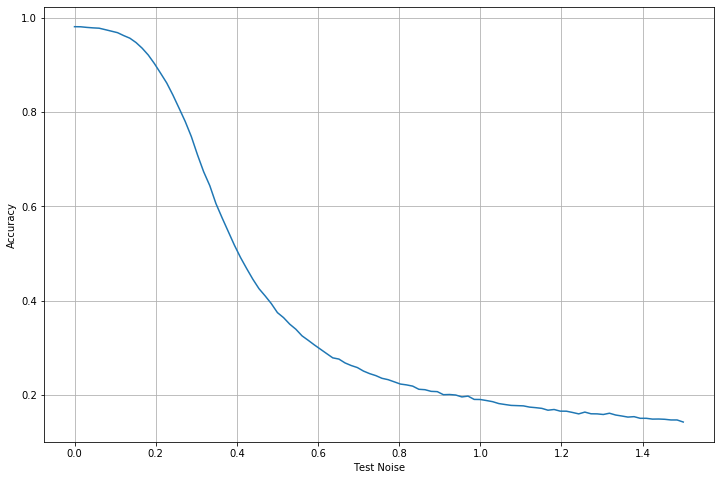

In [9]:
#creates plot of accuracy against added testing noise
plt.figure(figsize=(12,8))
plt.title('Model Accuracy with Different Noises Added to Testing Images')
plt.plot(y_noise,noises,label='Model Trained With No Noise')
plt.xlabel('Test Noise')
plt.ylabel('Accuracy')
plt.grid(True, axis ='both')

### Training with Noise
As we can see if the model is not trained with noise the accuracy decreases with as the noise added to the test images increases. So now we will try and find out which is the optimum noise to be added when training the model. 

In [10]:
y_noise2 = np.linspace(0,1.5,5)                 #array of different noises that will be added to training images
noises = np.zeros((len(y_noise2),len(y_noise))) #empty 2D-array to fill with accuracy data

#running multiple different models to find optimum noise
for i in range(len(y_noise2)):
    #initialises model
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28,28)),
            keras.layers.Dense(128,activation='sigmoid'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(128,activation='relu'),
            keras.layers.Dense(10)])
    
    #compiles model so that we can see how well the model is doing
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=tf.keras.optimizers.SGD(lr=1.0),metrics=['accuracy'])
    
    #fits model to training data with added noise
    model.fit(add_noise(train_images,y_noise2[i]), train_labels,batch_size=100, epochs=30,verbose=0)
    
    print('Step {} out of {}'.format(i+1,len(y_noise2)))
    
    #evaluates the model with different y_noises
    for j in range(len(y_noise)):
        test_loss, test_acc = model.evaluate(add_noise(test_images,y_noise[j]),  test_labels, verbose=0)
        noises[i,j] = test_acc

Step 1 out of 5
Step 2 out of 5
Step 3 out of 5
Step 4 out of 5
Step 5 out of 5


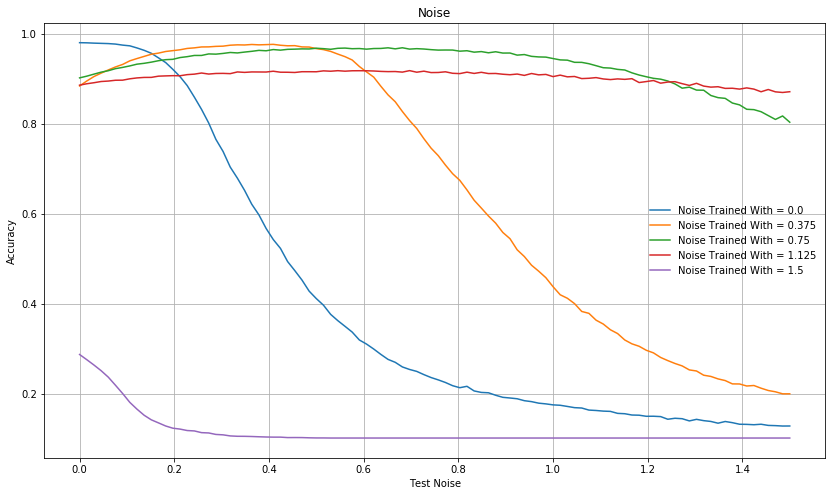

In [11]:
#plots the accuracy for each different model against the test noise
plt.figure(figsize=(14,8))
plt.title('Model Accuracy with Different Noises Added to Testing Images')
for i in range(len(y_noise2)):
    plt.plot(y_noise,noises[i],label = 'Noise Trained With = {}'.format(y_noise2[i]))
plt.xlabel('Test Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, axis ='both')

It seems from this that for the accuracy to be consistant over a larger range in test noises the model should be trained with noise from about $0.75$ and $1.125$. We we look more closely to find the optimum training noise.

### Finding the Best Values of Training Noise

To help me decide on what level of noise would be better I decided to train over 100 different $y_{noise}$ values so that I could determine where the best value for the training noise was. I have not left the code in a cell due to the amount of time it took me to compute this, but the python code used to get each point was (not too dissimilar to what is used above):
~~~
y_noise2 = np.linspace(0,1.5,100)               #array of different noises that are added to training images
noises = np.zeros((len(y_noise2),len(y_noise))) #empty 2D-array to fill with accuracy data

#running multiple different models to find optimum noise
for i in range(len(y_noise2)):
    #initialises model
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28,28)),
            keras.layers.Dense(128,activation='sigmoid'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(128,activation='relu'),
            keras.layers.Dense(10)])
    
    #compiles model so that we can see how well the model is doing
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=tf.keras.optimizers.SGD(lr=1.0),metrics=['accuracy'])
    
    #fits model to training data with added noise
    model.fit(add_noise(train_images,y_noise2[i]), train_labels,batch_size=100, epochs=30,verbose=0)
    
    print('Step {} out of {}'.format(i+1,len(y_noise2)))
    
    #evaluates the model with different y_noises
    for j in range(len(y_noise)):
        test_loss, test_acc = model.evaluate(add_noise(test_images,y_noise[j]),  test_labels, verbose=0)
        noises[i,j] = test_acc
~~~

Then simply plotting a line for each different training noise, the plot shown bellow is what I got. This is hard to gain any insight from. But using the array of accuracies for each different test noise I was then able to take an average accuracy of the range of test noises.

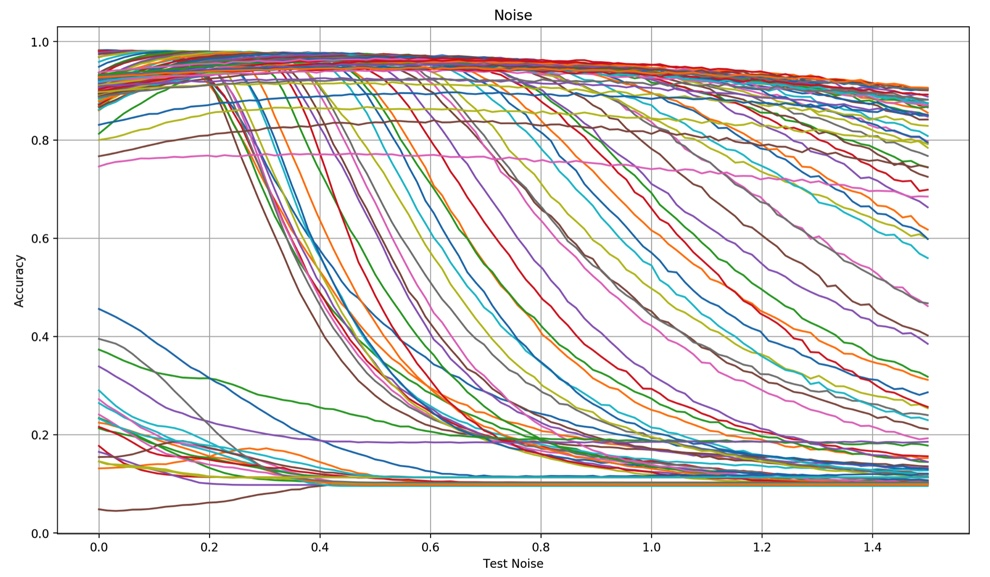

To work out the average accuracy I used the code bellow:
~~~
av_acc = np.zeros(len(y_noise2))
for i in range(len(y_noise2)):
    av_acc[i] = np.sum(noises[i])/len(noises[i])  
~~~
I then plotted the average accuracy against the noise the model was trained with to find out which values, for training noise, were best over the range of test noises.

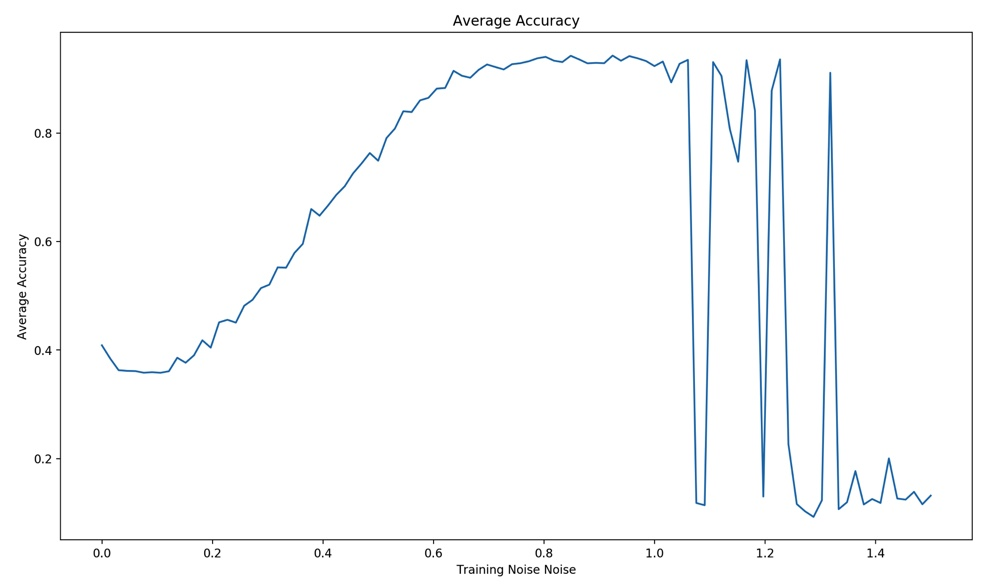

We can see in the above plot that as the noise added during training increases so too does the average accurcy. The average accuracy seems to peak inbetween $0.6$ and $1.05$, then following this due to the noise pottentially being more prominant than the initial image there is great variation in accuracies so might not consistantly work. So in the work bellow I will focus on the range stated.

In [12]:
y_noise2 = np.linspace(0.6,1.05,5)                 #array of different noises that will be added to training images
noises = np.zeros((len(y_noise2),len(y_noise))) #empty 2D-array to fill with accuracy data

#running multiple different models to find optimum noise
for i in range(len(y_noise2)):
    #initialises model
    model = keras.Sequential([
            keras.layers.Flatten(input_shape=(28,28)),
            keras.layers.Dense(128,activation='sigmoid'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(128,activation='relu'),
            keras.layers.Dense(10)])
    
    #compiles model so that we can see how well the model is doing
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                optimizer=tf.keras.optimizers.SGD(lr=1.0),metrics=['accuracy'])
    
    #fits model to training data with added noise
    model.fit(add_noise(train_images,y_noise2[i]), train_labels,batch_size=100, epochs=30,verbose=0)
    
    print('Step {} out of {}'.format(i+1,len(y_noise2)))
    
    #evaluates the model with different y_noises
    for j in range(len(y_noise)):
        test_loss, test_acc = model.evaluate(add_noise(test_images,y_noise[j]),  test_labels, verbose=0)
        noises[i,j] = test_acc

Step 1 out of 5
Step 2 out of 5
Step 3 out of 5
Step 4 out of 5
Step 5 out of 5


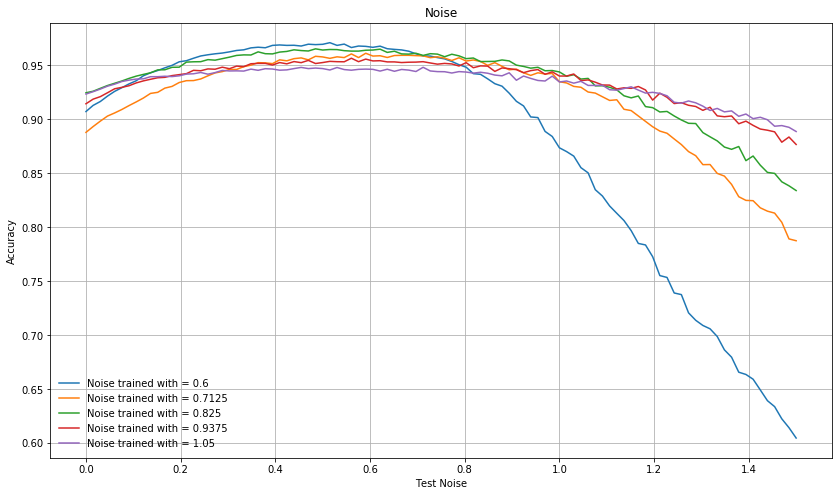

In [13]:
#plots the accuracy for each different model against the test noise
plt.figure(figsize=(14,8))
plt.title('Model Accuracy with Different Noises Added to Testing Images')
for i in range(len(y_noise2)):
    plt.plot(y_noise,noises[i],label = 'Noise trained with = {}'.format(y_noise2[i]))
plt.xlabel('Test Noise')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, axis ='both')

To see clearer which model is better, we will look to take the average of the accuracy over different ranges. This is because we can see that some models are good for low values of test noise but then drop off significantly when the noise increases too much. Whilst others are fairly consistent through out. So the ranges we will look at will be when the test noise is between $0$ and $1$, meaning the noise will not be greater than the top points of the image range. The other will be over all testing noises.

In [14]:
#average for test noise range 0-1.5 
av_acc = np.zeros(len(y_noise2))
for i in range(len(y_noise2)):
    av_acc[i] = np.sum(noises[i])/len(noises[i])  
    
#average for test noise range 0-1
av_acc2 = np.zeros(len(y_noise2))
for i in range(len(y_noise2)):
    av_acc2[i] = np.sum(noises[i,:75])/len(noises[i,:75]) 

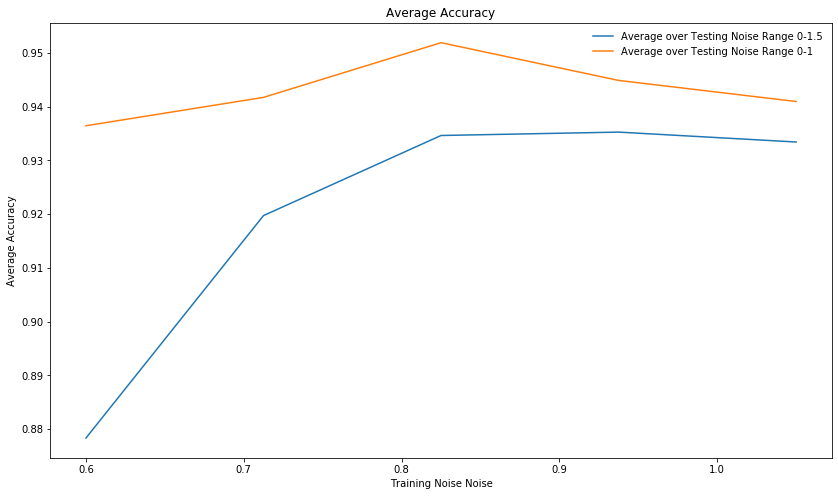

In [15]:
#plots the average accuracy against the noise that the model is trained with
plt.figure(figsize=(14,8))
plt.title('Average Accuracy')
plt.plot(y_noise2,av_acc,label = 'Average over Testing Noise Range 0-1.5' )
plt.plot(y_noise2,av_acc2,label = 'Average over Testing Noise Range 0-1')
plt.xlabel('Training Noise Noise')
plt.ylabel('Average Accuracy')
plt.legend()

### Conclusion
From this we can see that training with $y_{noise} = 0.825$ tends to be the best over both ranges, having repeated the modeling process multiple times. With this in mind I believe that this is the best noise to be added to training images to maximise performance. I would define perfomance, for a model, as how consistenly accurcate the model is over various different scenarios. In this case how accurate the model is over a range of different noises that are added to the testing images.   